# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

Wall time: 0 ns


# Overview
We illustrate the extraction of active barriers to the transport of momentum and vorticity as level sets of the Hamiltonian on 2-D homogeneous, isotropic turbulence. In 2D incompressible flows the Lagrangian and instantaneous active barrier equations are Hamiltonians. Convex level sets surrounding local maxima of the appropriate Hamiltonian block the transport of linear momentum and vorticity. In order to extract closed convex level sets of the Hamiltonian we emply the contour-finding algorithm used in the [LAVD](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/LAVD/find_outermost_contour.ipynb)-computation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Compute Hamiltonian of Lagrangian linear momentum barrier equation:

   <br />
   
   * For 2D incompressible, uniform-density Navier–Stokes flows, the Eulerian barrier equation for linear momentum is an autonomous Hamiltonian system of the form:
    
     \begin{equation}
     \mathbf{x}_0'=\nu \rho \mathbf{J} \mathbf{\nabla_0 \overline{\omega (\mathbf{F_{t_0}^{t}(\mathbf{x}_0)}, t)}},
     \label{eq: linearmomentum} 
     \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the aFTLE is only limited by the spatial resolution and domain. It can thus potentially reveal finer and more resolved structures compared to the classic version of the FTLE, which is fundamentally limited by the temporal domain of the available data.
    
    The Hamiltonian $ \mathrm{H}_{t_0}^{t_N}(\mathbf{x}_0) $ is given by:
    
    \begin{equation}
    \mathrm{H}_{t_0}^{t_N}(\mathbf{x}_0) = \nu \rho \overline{\omega (\mathbf{F_{t_0}^t}(\mathbf{x}_0, t)},
    \label{eq: HamiltonianLinearMomentum}
    \end{equation}
    
    <br />
    
   * We start by evaluating the right-hand-side of equation \ref{eq: HamiltonianLinearMomentum} by interpolating $ \overline{\omega (\mathbf{F_{t_0}^t}(\mathbf{x}_0, t)} $ over the spatial meshgrid.
   
   <br />
   
   * We then find almost convex structurally stable level sets of $ \mathrm{H}_{t_0}^{t_N}(\mathbf{x}_0) $

# Import Data

In [2]:
%%time
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

omega = np.zeros((1024, 1024, 251))

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

Wall time: 35.1 s


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 4

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [1]:
# specify time at which to compute instantaneous momentum barriers (this should an integer in [0, 249])
t0 = 0

Nx = 300
Ny = 300

# specify domain over which to compute linear momentum barriers
x_domain = np.linspace(4.2, 5, 300) # array (Nx,)
y_domain = np.linspace(2.2, 3, 300) # array (Ny,)

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

# define dummy time interval
ds = 0.002 # float
sN = 0.25 # float Feel free to change this parameter as needed
s_dummy = np.arange(0, tN+ds, ds) # array (Ns, )

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/100]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

NameError: name 'np' is not defined

# Instantaneous linear momentum barriers

We visualize linear momentum barriers by applying the FTLE-field to the trajectories of system \ref{eq: linearmoment}. As soon as the FTLE-field is applied to an active vector field, such as linear momentum, we refer to it as aFTLE (active FTLE). We will subsequently compare the results with the classic version of the instantaneous FTLE-field which is given by the maximum eigenvalue of the rate of strain tensor.

## Interpolate instantaneous momentum barrier field

We start by computing the interpolant for the instantaneous momentum barrier field. The interpolant is given by the right-hand-side of equation \ref{eq: linearmoment}.

In [5]:
%%time
# Import interpolation function for instantaneous active momentum barrier equation
from ipynb.fs.defs.HamiltonianActiveMomentum import InstantaneousActiveMomentum

# Interpolate RHS of linear momentum barrier equation using cubic spatial interpolation
Interpolant_momentum = InstantaneousActiveMomentum(X, Y, omega[:,:,t0], aux_grid)

Wall time: 20 s


## Compute trajectories

In the following we compute trajectories over a meshgrid. The integration is vectorized by arranging the initial conditions to a vector. As we need to compute the gradient of the flow map, we seed around each initial condition four particles on an auxiliary meshgrid. For each initial condition we hence have in total 5 particle trajectories (four auxiliary trajectories+original trajectory).

In [6]:
%%time
# Import gradient of flow map
from ipynb.fs.defs.RK4_integration import RK4_integration

# Import package which computes eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# initial conditions of auxiliary grid
x0_init, y0_init = X_domain.ravel(), Y_domain.ravel()
x0_init_R = x0_init + aux_grid[0]
x0_init_L = x0_init - aux_grid[0]
y0_init_U = y0_init + aux_grid[1]
y0_init_D = y0_init - aux_grid[1]

# create array which stores solution of particle trajectories
solODE = np.zeros((len(s_dummy), 2, len(x0_init), 5))
        
Interpolant_momentum_x = Interpolant_momentum[0]
Interpolant_momentum_y = Interpolant_momentum[1]
ds = s_dummy[1]-s_dummy[0]

# initial conditions of auxiliary grid
r0 = np.array([x0_init, y0_init]) # shape (len(x0_init), 2)
r0R = np.array([x0_init_R, y0_init]) # shape (len(x0_init), 2)
r0L = np.array([x0_init_L, y0_init]) # shape (len(x0_init), 2)
r0U = np.array([x0_init, y0_init_U]) # shape (len(x0_init), 2)
r0D = np.array([x0_init, y0_init_D]) # shape (len(x0_init), 2)

# solODE stores trajectories launched from auxiliary grid
solODE[0,:,:,0] = r0
solODE[0,:,:,1] = r0R
solODE[0,:,:,2] = r0L
solODE[0,:,:,3] = r0U
solODE[0,:,:,4] = r0D

# iterate over all trajectories from auxiliary grid (this is parallellized)
def trajectories_auxiliary_grid(solODE):
    
    solODE_parallel = solODE.copy()
    
    # iterate over dummy time
    for i in range(len(s_dummy)-1):
        solODE_parallel[i+1,:,:] = RK4_integration(solODE_parallel[i,:,:], ds, Interpolant_momentum[0], Interpolant_momentum[1])
    
    return solODE_parallel

# compute trajectories over meshgrid
solODE = np.array(Parallel(n_jobs=5, verbose = 0)(delayed(trajectories_auxiliary_grid)(solODE[:,:,:,i]) for i in range(5)))
solODE= np.transpose(solODE, (1, 2, 3, 0))

Wall time: 1min 42s


## Compute active FTLE

We now compute the active FTLE for the instantaneous linear momentum barrier equations. First, we evaluate the active Cauchy-Green strain tensor from the gradient of the active flow map over the meshgrid. The active flow map is given by the solution of the autonomous ODE from equation \ref{eq: linearmoment}. Finally, we apply the classic FTLE to the active Cauchy-Green strain tensor.

In [7]:
# Import package for computing CauchyGreen (CG) strain tensor
from ipynb.fs.defs.CauchyGreen import CauchyGreen

# Import package for computing Finite-Time Lyapunov Exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# compute aFTLE
aFTLE = [[], [], []]

s1 = 0.05
s2 = 0.15
s3 = 0.25

s = [0.05, 0.15, 0.25]

for i in tqdm(range(solODE.shape[2])):
    
    counter = 0
    for idx in np.searchsorted(s_dummy, s):
    
        xR = solODE[idx,0,i,1]
        xL = solODE[idx,0,i,2]
        yR = solODE[idx,1,i,1]
        yL = solODE[idx,1,i,2]
    
        xU = solODE[idx,0,i,3]
        xD = solODE[idx,0,i,4]
        yU = solODE[idx,1,i,3]
        yD = solODE[idx,1,i,4]
    
        gradFmap = np.zeros((2,2))*np.nan
    
        gradFmap[0,0] = (xR-xL)/(2*aux_grid[0])
        gradFmap[0,1] = (xU-xD)/(2*aux_grid[0])
        gradFmap[1,0] = (yR-yL)/(2*aux_grid[1])
        gradFmap[1,1] = (yU-yD)/(2*aux_grid[1])
    
        # Cauchy Green strain tensor
        C = CauchyGreen(gradFmap)
    
        # aFTLE over [0,s]
        aFTLE[counter].append(_FTLE(C, s_dummy[idx]))
        
        counter += 1

  0%|          | 0/160000 [00:00<?, ?it/s]

## Compute instantaneous (classic) FTLE-field

The instananeous (classic) FTLE-field at time 't' is given by the maximum eigenvalue of the rate of strain tensor. The rate of strain tensor is computed from the gradient of the velocity field at time 't':

\begin{equation}
\mathbf{S}(\mathbf{x}, t) = \dfrac{1}{2}(\mathbf{\nabla v}(\mathbf{x}, t)+\mathbf{\nabla v}(\mathbf{x}, t)^T)
\end{equation}

### Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [8]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

Wall time: 38.2 s


### Maximum eigenvalue of rate of strain tensor 

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. $ (\mathbf{x}, t) $ is computed from the gradient of the velocity field by using an auxiliary meshgrid.

In [9]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package which computes eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import gradient of velocity function
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import Rate of Strain function
from ipynb.fs.defs.RateStrain import RateStrain

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

def parallel_inst_FTLE(i):
    
    inst_FTLE_parallel = X_domain[0,:].copy()*np.nan
    
    for j in range(inst_FTLE_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # Compute gradient of velocity
        grad_vel = gradient_velocity(t0, x, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
    
        # Compute eigenvalue of rate of strain at 'x'
        
        inst_FTLE_parallel[j] = eigen(RateStrain(grad_vel[:,:,0]))[1]
    
    return inst_FTLE_parallel

# compute instantaneous FTLE with parallel computing
inst_FTLE = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_inst_FTLE)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/400 [00:00<?, ?it/s]

Wall time: 28min 56s


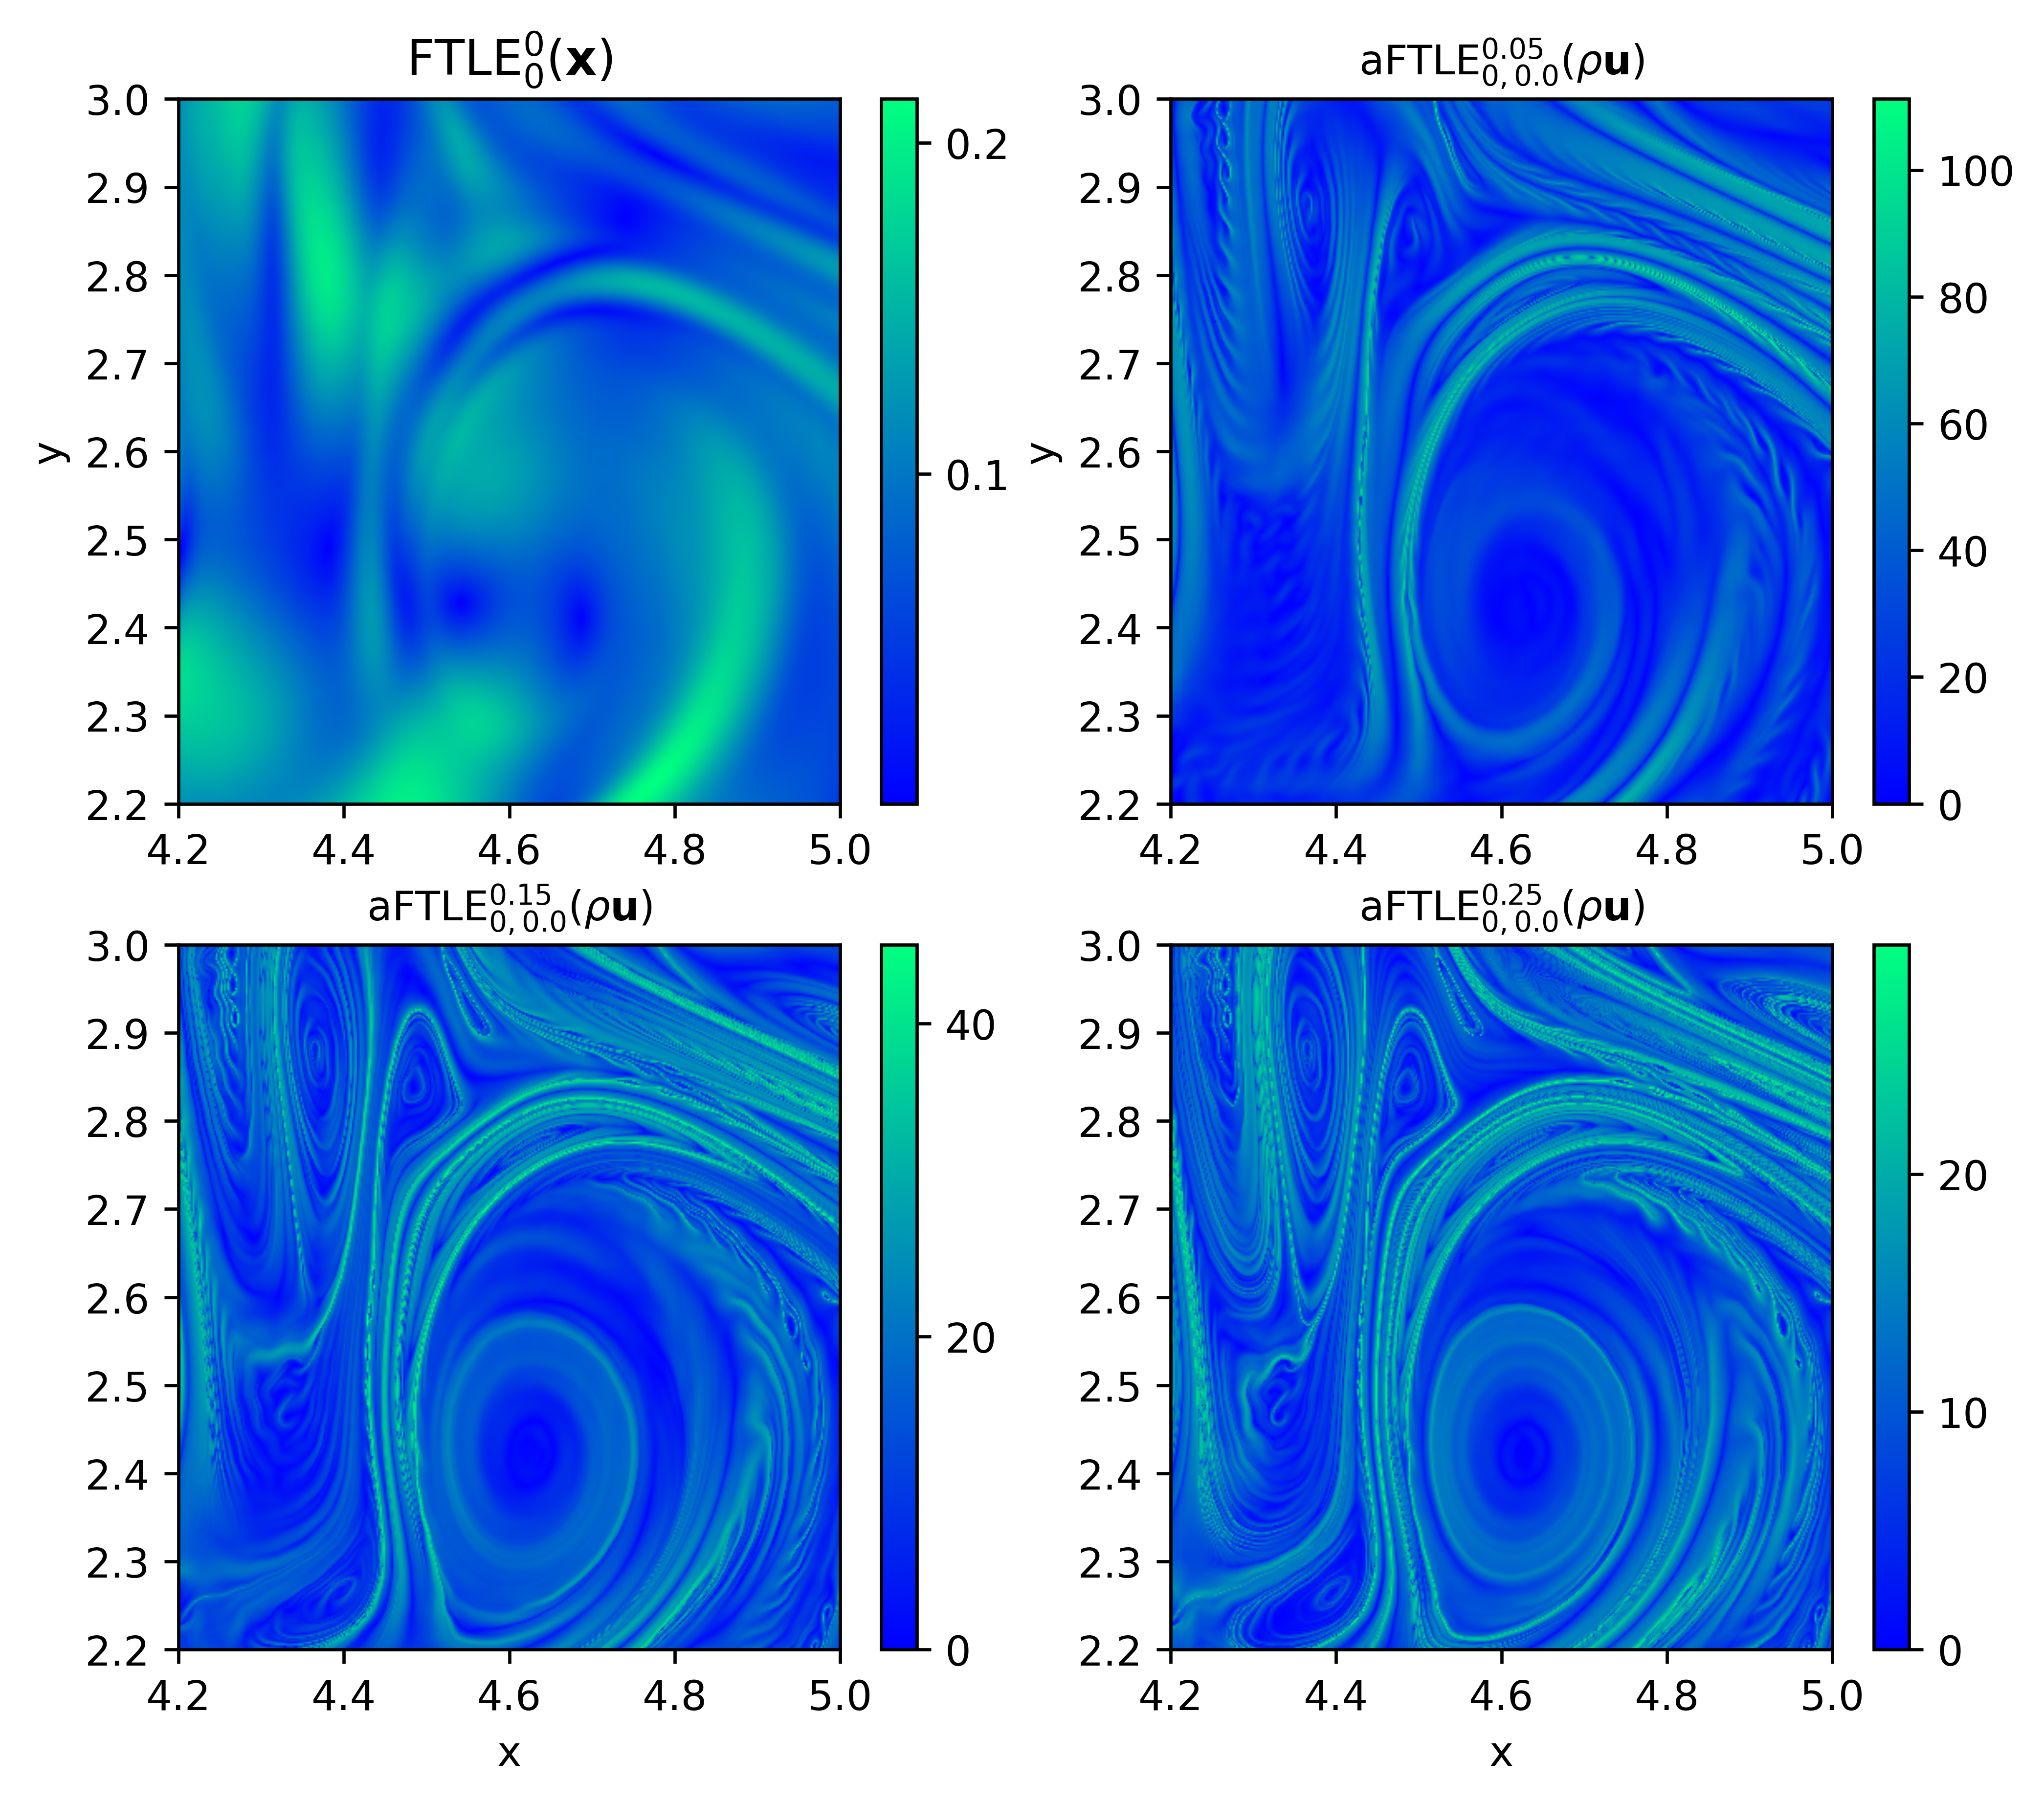

In [10]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, dpi = 600, figsize=(8, 7))

# Contourplot of instantaneous classic FTLE at time 't=0' over meshgrid of initial conditions
cax = ax0.contourf(X_domain, Y_domain, inst_FTLE, cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.linspace(0, 0.4, 5))

# Contourplot of aFTLE_0^0.05 over meshgrid of initial conditions
cax = ax1.tricontourf(x0_init, y0_init, aFTLE[0], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.linspace(0, 100, 6))

# Contourplot of aFTLE_0^0.15 over meshgrid of initial conditions
cax = ax2.tricontourf(x0_init, y0_init, aFTLE[1], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax2, ticks = np.linspace(0, 100, 6))

# Contourplot of aFTLE_0^0.25 over meshgrid of initial conditions
cax = ax3.tricontourf(x0_init, y0_init, aFTLE[2], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax3, ticks = np.linspace(0, 50, 6))

# Axis Labels
ax2.set_xlabel("x", fontsize = 10)
ax3.set_xlabel("x", fontsize = 10)
ax0.set_ylabel("y", fontsize = 10)
ax1.set_ylabel("y", fontsize = 10)

ax0.set_title(r'$\mathrm{FTLE}_{0}^{0}(\mathbf{x})$')
ax1.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[0])], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)
ax2.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[1])], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)
ax3.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[2])], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)

plt.show()

The figures focus on momentum-based active barriers in one of the vortical regions of the two-dimensional turbulence model. 
As expected the FTLE has a very weak signature when considering the instantaneous limit. On the other hand, the aFTLE provides a clear picture the main vortex and active hyperbolic barriers. The features become even more pronounced for longer s-times, revealing several secondary vortices around its neighbourhood. None of these vortices are present in the classic instantaneous FTLE. Ridges of the FTLE reveal barriers which block the transport of linear momentum.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.